# Import

In [ ]:
# Standard libraries
import sys
import copy
from datetime import datetime

# Data processing
import numpy as np
import pandas as pd
import cv2
from PIL import Image

# Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Visualization
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# Project-specific imports
sys.path.insert(0, './atarihead')
sys.path.insert(0, '../src')
from replay_buffer import HDF5ReplayBufferRAM
from models import Autoencoder, Gaze_predictor_pool
from utils import get_lr

# Configuration
pd.options.display.float_format = '{:.3g}'.format
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

# IPython display setup
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

# Load Atarihead replay buffer

In [ ]:
# List of Atari games to process
games = [
    'alien', 'asterix', 'bank_heist', 'berzerk', 'breakout', 'centipede',
    'demon_attack', 'enduro', 'freeway', 'frostbite', 'hero', 'montezuma_revenge',
    'ms_pacman', 'name_this_game', 'phoenix', 'riverraid', 'road_runner',
    'seaquest', 'space_invaders', 'venture'
]

# Mapping from Atari Agents to Atarihead naming
AA_to_AH = {
    'Alien': 'alien', 'Asterix': 'asterix', 'BankHeist': 'bank_heist',
    'Berzerk': 'berzerk', 'Breakout': 'breakout', 'Centipede': 'centipede',
    'DemonAttack': 'demon_attack', 'Enduro': 'enduro', 'Freeway': 'freeway',
    'Frostbite': 'frostbite', 'Hero': 'hero', 'MontezumaRevenge': 'montezuma_revenge',
    'MsPacman': 'ms_pacman', 'NameThisGame': 'name_this_game', 'Phoenix': 'phoenix',
    'Riverraid': 'riverraid', 'RoadRunner': 'road_runner', 'Seaquest': 'seaquest',
    'SpaceInvaders': 'space_invaders', 'Venture': 'venture'
}

In [ ]:
# Configuration
game_name = '...'
flag_load_encoded_grid_tensor = True
train_val_split = 0.8

# Load replay buffer
memory = HDF5ReplayBufferRAM.load(
    file_path=f'replay_buffers/atarihead/{AA_to_AH[game_name]}_atarihead_buffer_all_4f_84gray.h5',
    file_rw_option='r', 
    train_val_split=train_val_split, 
    RAM_ratio=1/1
)

# Autoencoder checkpoint dates
AE_datecodes = {
    'Enduro': '2025-07-01-10-35',
    'Freeway': '2025-06-16-12-34',
    'MsPacman': '2025-06-16-12-14',
    'Riverraid': '2025-07-02-13-42',
    'Seaquest': '2025-07-02-17-47',
    'SpaceInvaders': '2025-07-02-20-06'
}

# Load pre-trained autoencoder
checkpoint_path = f'trained_models/autoencoder/AE_4f_TCDS_BlurPool64_{game_name}_{AE_datecodes[game_name]}.pkl'
checkpoint = torch.load(checkpoint_path, weights_only=True, map_location=device)
autoencoder = Autoencoder(device).to(device)
autoencoder.load_state_dict(checkpoint['state'])
autoencoder.eval()

game_res = (84, 84, 1)

# Load gaze target

In [ ]:
# Load gaze target data
gaze_target_np = np.load(f'other/{game_name}_gaze_target_all_4f_v6.npy')

# Definition of training loop

In [ ]:
def train_gaze_predictor(gaze_predictor, gaze_predictor_optimizer, memory, batch_size):
    """Train the gaze predictor model."""
    results = [[], []]

    # Sample data from replay buffer
    state_np_all, _, _, _, gaze_positions_all, _, train_flags, idxs_all = memory.sample_stacked_fwd(
        int(batch_size/train_val_split), return_idxs=True
    )
    state_all = torch.tensor(state_np_all, dtype=torch.float32, device=device) / 255.0 * 2 - 1
    non_nan_mask_all = ~np.isnan(gaze_positions_all[:, -1]).any(axis=1)

    # Training loop for both train and validation
    for sample_mode, state, non_nan_mask, idxs, id_train in zip(
        ['train', 'val'],
        [state_all[train_flags], state_all[~train_flags]],
        [non_nan_mask_all[train_flags], non_nan_mask_all[~train_flags]],
        [idxs_all[train_flags], idxs_all[~train_flags]],
        [0, 1]
    ):
        if sample_mode == 'val':
            gaze_predictor.eval()

        # Get gaze targets
        gaze_target_slices = gaze_target_np[idxs]
        gaze_target = torch.tensor(gaze_target_slices, device=device, dtype=torch.float32)
        gaze_target = gaze_target.flatten(start_dim=1)

        # Forward pass
        gaze_predict = gaze_predictor(state).flatten(start_dim=1)
        gaze_loss = F.kl_div(gaze_predict.log(), gaze_target, reduction='batchmean')

        # Backward pass for training
        if sample_mode == 'train':
            gaze_predictor_optimizer.zero_grad()
            gaze_loss.backward()
            torch.nn.utils.clip_grad_norm_(gaze_predictor.parameters(), 1.0)
            gaze_predictor_optimizer.step()
            
        if sample_mode == 'val':
            gaze_predictor.train()

        results[id_train] = gaze_loss.item()
    
    return np.array(results)

# Training

## Setup

In [ ]:
# Training configuration
lr = 3e-4
batch_size = 128
min_lr = 1e-6

# Initialize gaze predictor
gaze_predictor = Gaze_predictor_pool(device, copy.deepcopy(autoencoder)).to(device)
gaze_predictor_optimizer = optim.AdamW(
    gaze_predictor.parameters(), 
    lr=lr, 
    weight_decay=1e-2
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(
    gaze_predictor_optimizer, 
    step_size=150, 
    gamma=0.1
)


## Run training

In [ ]:
# Training parameters
n_batches = 100
n_epochs = 200

# Initialize tracking
loss_df = pd.DataFrame(columns=['q-epoch', 'lr', 'l_train', 'l_val'])
gaze_loss_sum, i, current_epoch = 0, 0, 1

In [ ]:

# Main training loop
for j in range(n_epochs - current_epoch + 1):
    # Training batches
    for i in range(n_batches):    
        gaze_loss = train_gaze_predictor(gaze_predictor, gaze_predictor_optimizer, memory, batch_size)
        gaze_loss_sum += gaze_loss

    # Calculate average loss
    avg_loss = gaze_loss_sum / n_batches

    # Record results
    current_lr = get_lr(gaze_predictor_optimizer)
    loss_df.loc[current_epoch - 1] = [current_epoch, current_lr, *avg_loss]
    
    # Check for NaN values
    if np.isnan(avg_loss[0]) or np.isnan(avg_loss[1]):
        break
    else:
        clear_output()

    # Display progress
    print(loss_df.tail(30))
    scheduler.step()
    gaze_loss_sum = 0
    current_epoch += 1
    memory.shuffle_RAM()
    print('Replay buffer RAM shuffled.')

    # Stop if learning rate reaches minimum
    if current_lr == min_lr:
        break

---
conv1 weight sum: -1.7163012027740479
BN1 running mean: tensor([-0.0011, -0.0051, -0.0049,  0.0013,  0.0085], device='cuda:0')
BN1 running var: tensor([0.0012, 0.0250, 0.0292, 0.0041, 0.0069], device='cuda:0')
---
conv1 weight sum: -1.7163012027740479
BN1 running mean: tensor([-0.0011, -0.0051, -0.0049,  0.0013,  0.0085], device='cuda:0')
BN1 running var: tensor([0.0012, 0.0250, 0.0292, 0.0041, 0.0069], device='cuda:0')
    q-epoch     lr  l_train  l_val
0         1 0.0003     1.38   1.38
1         2 0.0003     1.06   1.05
2         3 0.0003     1.05   1.05
3         4 0.0003     1.05   1.05
4         5 0.0003     1.05   1.04
5         6 0.0003     1.04   1.03
6         7 0.0003     1.11   1.11
7         8 0.0003    0.914  0.903
8         9 0.0003    0.857  0.844
9        10 0.0003    0.837  0.835
10       11 0.0003    0.816  0.813
11       12 0.0003    0.807   0.81
12       13 0.0003    0.805  0.804
13       14 0.0003     0.79  0.794
14       15 0.0003    0.788  0.798
15       16 

KeyboardInterrupt: 

# Plot losses

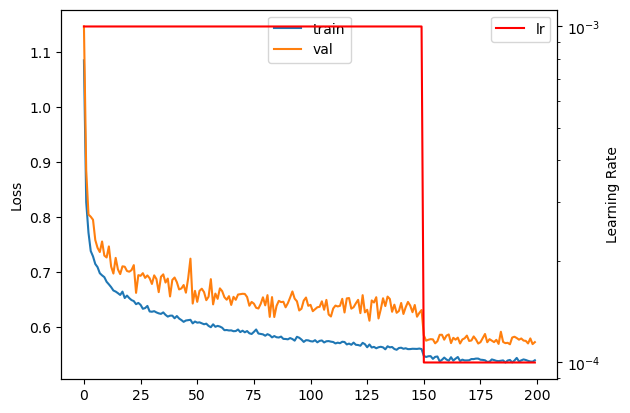

In [ ]:
# Plot training progress
fig, ax1 = plt.subplots()

# Plot losses
ax1.plot(loss_df['l_train'].rolling(1).mean(), label='train')
ax1.plot(loss_df['l_val'].rolling(1).mean(), label='val')
ax1.set_ylabel('Loss')
ax1.legend(loc='upper center')

# Plot learning rate
ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.plot(loss_df['lr'], label='lr', color='r')
ax2.set_ylabel('Learning Rate')
ax2.legend(loc='upper right')

plt.show()


# Gaze predictor analysis

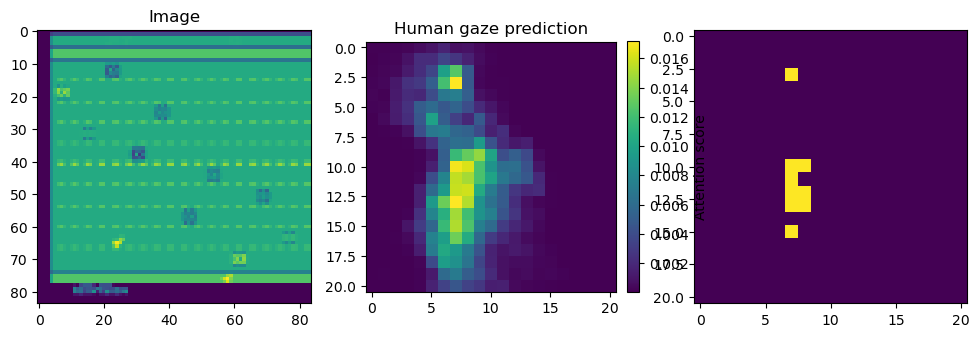

In [ ]:
# Gaze predictor analysis
gaze_limit = 0.015
i_print = np.random.randint(batch_size)

# Sample data for analysis
state_np, actions, rewards, frame_ids, gaze_positions, done_np, _ = memory.sample_stacked_fwd(
    batch_size, consecutive=True
)

state_torch=torch.tensor(state_np/255*2-1,device=device,dtype=torch.float32)

gaze_pos = np.array(gaze_positions[i_print])
state_img=((state_torch.cpu().detach().numpy()+1)/2*255).astype(np.uint8)
gaze_pred=gaze_predictor(state_torch)

gaze_pred_img=gaze_pred[i_print].cpu().detach().numpy()

fig,ax=plt.subplots(1,3,figsize=(12,6))
ax[0].imshow(state_img[i_print][...,-1])
ax[0].set_title('Image')


im = ax[1].imshow(gaze_pred_img)
ax[1].set_title('Human gaze prediction')
fig.colorbar(im, ax=ax[1], label='Attention score', fraction=0.046, pad=0.04)
im = ax[2].imshow(gaze_pred_img>gaze_limit)



# Animation with gaze predictor

In [ ]:
n_frames=300
gaze_limit=0.005

state_np, actions, rewards, frame_ids, gaze_positions, done_np,_,idxs=memory.sample_stacked_fwd(n_frames,consecutive=True,return_idxs=True)

frames = [Image.fromarray(entry[...,:-1]) for entry in state_np]
frames_att=frames

state_torch=torch.tensor(state_np/255*2-1,device=device,dtype=torch.float32)

for i in range(n_frames):
    state_torch=torch.tensor(state_np[i]/255*2-1,device=device,dtype=torch.float32).unsqueeze(0)

    psiTD_np=gaze_predictor(state_torch).detach().cpu().numpy()[0]
    
    psiTD_np=(psiTD_np>gaze_limit).astype(np.float32) 
    gaze_target_now=(gaze_target_np[idxs[i],0]>gaze_limit).astype(np.float32) 

    psiTD_np_stretch = np.expand_dims(cv2.resize(psiTD_np, (84, 84), interpolation=cv2.INTER_LINEAR),2)
    gaze_target_now_stretch = np.expand_dims(cv2.resize(gaze_target_now, (84,84), interpolation=cv2.INTER_LINEAR),2)
    
    alpha = 0.5
    original_frame = np.array(frames_att[i])  # Convert frame to NumPy array

    blended_frame = (alpha * original_frame + (1 - alpha) * psiTD_np_stretch*original_frame).astype(np.uint8)
    frames_att[i] = Image.fromarray(blended_frame)

frames[0].save(
    fr'Gifs/Gaze_predictor_training/GP_test_{game_name}.gif', 
    save_all=True, 
    append_images=frames[1:], 
    duration=1/60,
    loop=0  # Infinite loop
)

# Save gaze predictor

In [ ]:
now = datetime.now().strftime("%Y-%m-%d-%H-%M")

gaze_checkpoint = {
    'model_state': gaze_predictor.state_dict(),
    'optimizer_state': gaze_predictor_optimizer.state_dict()}

loss_df.to_csv(fr'trained_models/gaze_predictor/gaze_df_4f_{game_name}_{now}.csv', index=False) 
with open(fr'trained_models/gaze_predictor/gaze_predictor_4f_{game_name}_{now}.pkl', 'wb') as f:
    torch.save(gaze_checkpoint, f)